# Trabajo practico: Prediccion de lluvia Australia

Alumnos: Noir Nicolas, González Ignacio

Año: 2024

Materia: Aprendizaje automático 1

Carrera: TUIA

# Librerias

In [1]:
#!pip install scikit-learn
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install plotly

In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import plotly.figure_factory as ff
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.exceptions import DataConversionWarning
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning

# Libreria necesaria para poder ocultar errores que empeoran la visualización del notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
dataset_lluvia_completo_raw = pd.read_csv('https://raw.githubusercontent.com/nacho-gonz/AA1-Archivos-2024/master/weatherAUS.csv')
ciudades_elegidas = dataset_lluvia_completo_raw["Location"].sample(10, random_state=528548).to_list()
df_ciudad = dataset_lluvia_completo_raw[dataset_lluvia_completo_raw["Location"].isin(ciudades_elegidas)]
df_ciudad.dropna(subset=['RainTomorrow'], inplace=True)

In [4]:
mapa_puntos = {'NNE': 'NE', 'ENE': 'E', 'ESE': 'SE', 'SSE': 'S', 'SSW': 'SW', 'WSW': 'W', 'WNW': 'NW', 'NNW': 'N'}
df_ciudad['WindGustDir'] = df_ciudad['WindGustDir'].replace(mapa_puntos)
df_ciudad['WindDir9am'] = df_ciudad['WindDir9am'].replace(mapa_puntos)
df_ciudad['WindDir3pm'] = df_ciudad['WindDir3pm'].replace(mapa_puntos)

df_ciudad['Date'] = pd.to_datetime(df_ciudad['Date'])
df_ciudad['Month'] = df_ciudad['Date'].dt.month
df_ciudad.drop('Date', axis=1, inplace=True)

dataset_ciudad_codificado = pd.get_dummies(df_ciudad, columns=['WindGustDir','WindDir9am','WindDir3pm', 'RainToday','Month','Location'], drop_first=True)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(dataset_ciudad_codificado.drop("RainTomorrow", axis=1), dataset_ciudad_codificado['RainTomorrow'].values.reshape(-1,1), test_size=0.15, random_state=28869)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1765, random_state=1765)

In [6]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((20207, 58), (4331, 58), (4331, 58), (20207, 1), (4331, 1), (4331, 1))

In [7]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20207 entries, 126064 to 103915
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MinTemp              19970 non-null  float64
 1   MaxTemp              20060 non-null  float64
 2   Rainfall             20010 non-null  float64
 3   Evaporation          10587 non-null  float64
 4   Sunshine             12096 non-null  float64
 5   WindGustSpeed        17619 non-null  float64
 6   WindSpeed9am         19829 non-null  float64
 7   WindSpeed3pm         19334 non-null  float64
 8   Humidity9am          19991 non-null  float64
 9   Humidity3pm          19531 non-null  float64
 10  Pressure9am          15866 non-null  float64
 11  Pressure3pm          15863 non-null  float64
 12  Cloud9am             14834 non-null  float64
 13  Cloud3pm             13768 non-null  float64
 14  Temp9am              20057 non-null  float64
 15  Temp3pm              19563 non-null

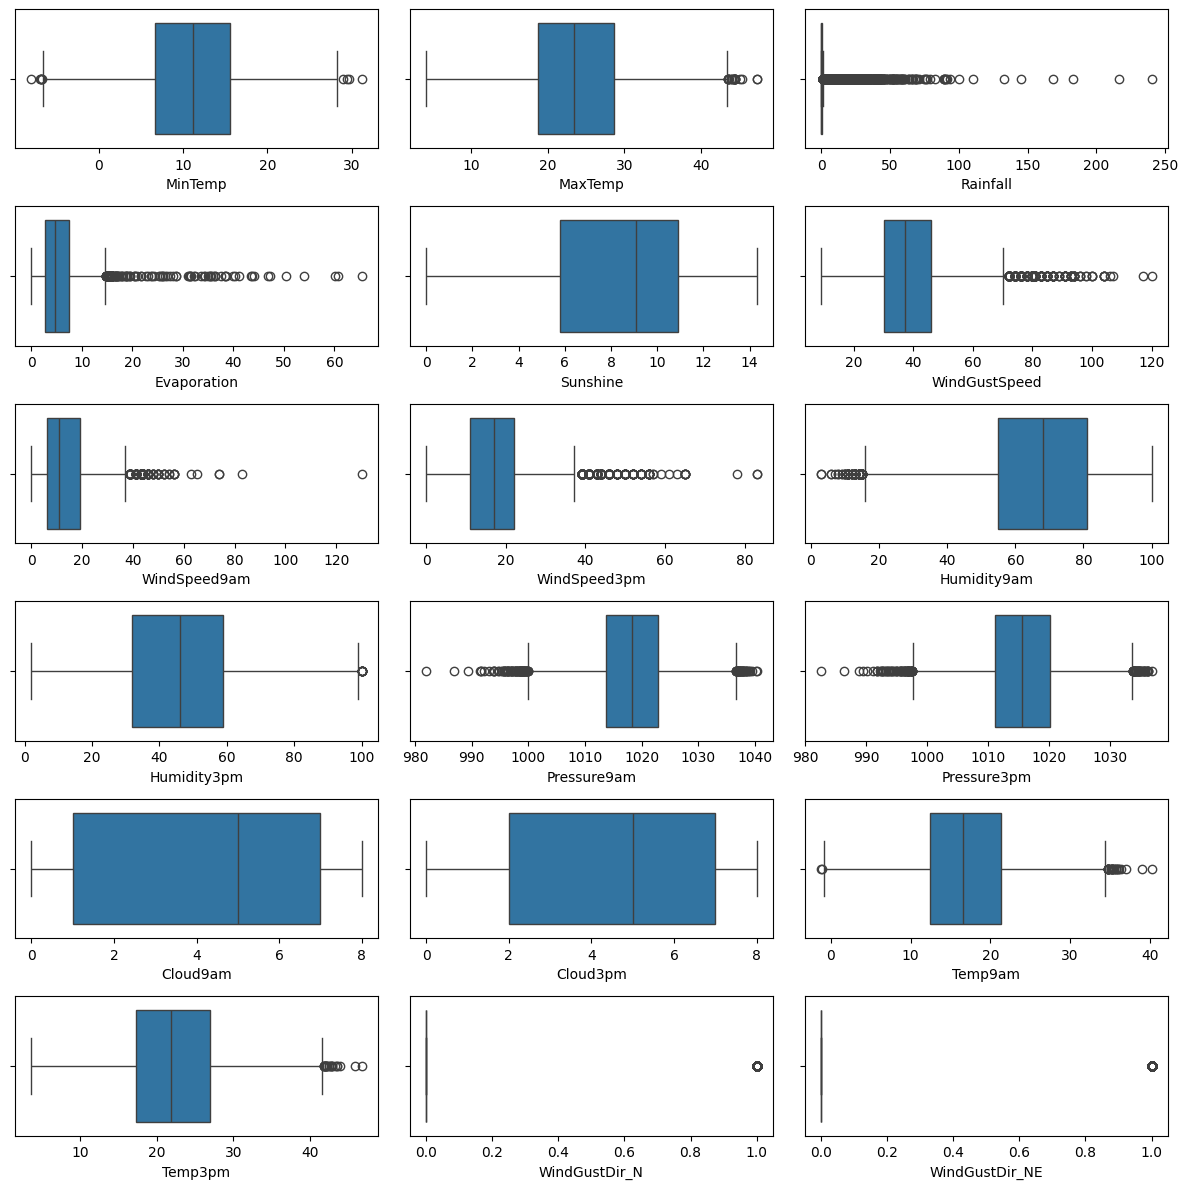

In [8]:
fig, axes = plt.subplots(6,3)

for name, ax in zip(x_train, axes.flatten()):
    sns.boxplot(x=name, data=x_train, orient='h', ax=ax)

fig.set_size_inches(12,12)
plt.tight_layout()
plt.show()

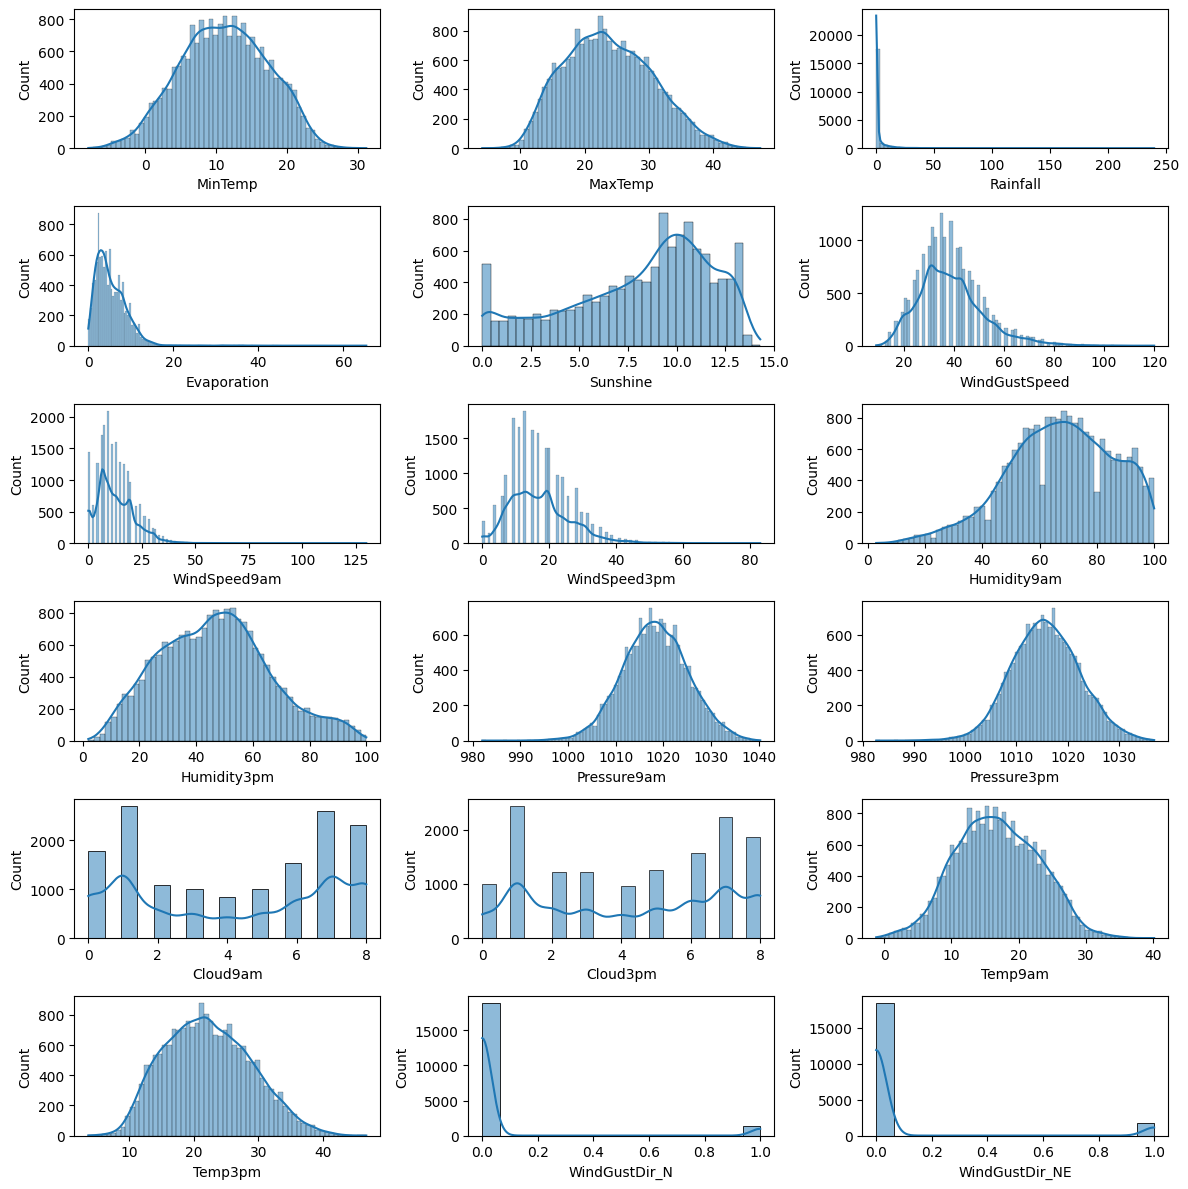

In [9]:
fig2, axes2 = plt.subplots(6,3)

for name, ax in zip(x_train, axes2.flatten()):
    if name == "Rainfall":
        sns.histplot(x=name, data=x_train, ax=ax,kde=True, bins=70)
    else:
        sns.histplot(x=name, data=x_train, ax=ax,kde=True)

fig2.set_size_inches(12,12)
plt.tight_layout()
plt.show()

In [19]:
modelo_escalado_imputado = make_pipeline(MinMaxScaler(),KNNImputer(n_neighbors=10)).set_output(transform='pandas')
x_train_imp_esc = modelo_escalado_imputado.fit_transform(x_train, y_train)
x_test_imp_esc = modelo_escalado_imputado.transform(x_test)
x_val_imp_esc = modelo_escalado_imputado.transform(x_val)

In [21]:
def redondiar_valores(df, lista):
    for var in lista:
        if var == ['Cloud3pm'] or ['Cloud9am']:
            df[var] = df[var].round(1)
            df[var] = df[var].replace([0.9, 1.0], 0.8)
        else:
            df[var] = df[var].round().astype('bool')
    return df

variables_a_cambiar = ['Cloud9am', 'Cloud3pm', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SW',
       'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SW', 'WindDir3pm_W', 'RainToday_Yes',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Location_Canberra', 'Location_Moree', 'Location_Newcastle', 'Location_Nhil', 'Location_Nuriootpa', 'Location_PearceRAAF',
       'Location_Perth', 'Location_Sale', 'Location_SalmonGums']

x_train_imp_esc_red = redondiar_valores(x_train_imp_esc, variables_a_cambiar)
x_test_imp_esc_red = redondiar_valores(x_test_imp_esc, variables_a_cambiar)
x_val_imp_esc_red = redondiar_valores(x_val_imp_esc, variables_a_cambiar)

In [1]:
df_train_completo = x_train_imp_esc_red.copy()
df_train_completo['RainTomorrow'] = y_train

NameError: name 'x_train_imp_esc_red' is not defined

In [ ]:
df_pairplot = df_train_completo['Cloud9am', 'Cloud3pm', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SW',
       'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SW', 'WindDir3pm_W', 'RainToday_Yes',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Location_Canberra', 'Location_Moree', 'Location_Newcastle', 'Location_Nhil', 'Location_Nuriootpa', 'Location_PearceRAAF',
       'Location_Perth', 'Location_Sale', 'Location_SalmonGums','RainTomorrow']

sns.pariplot

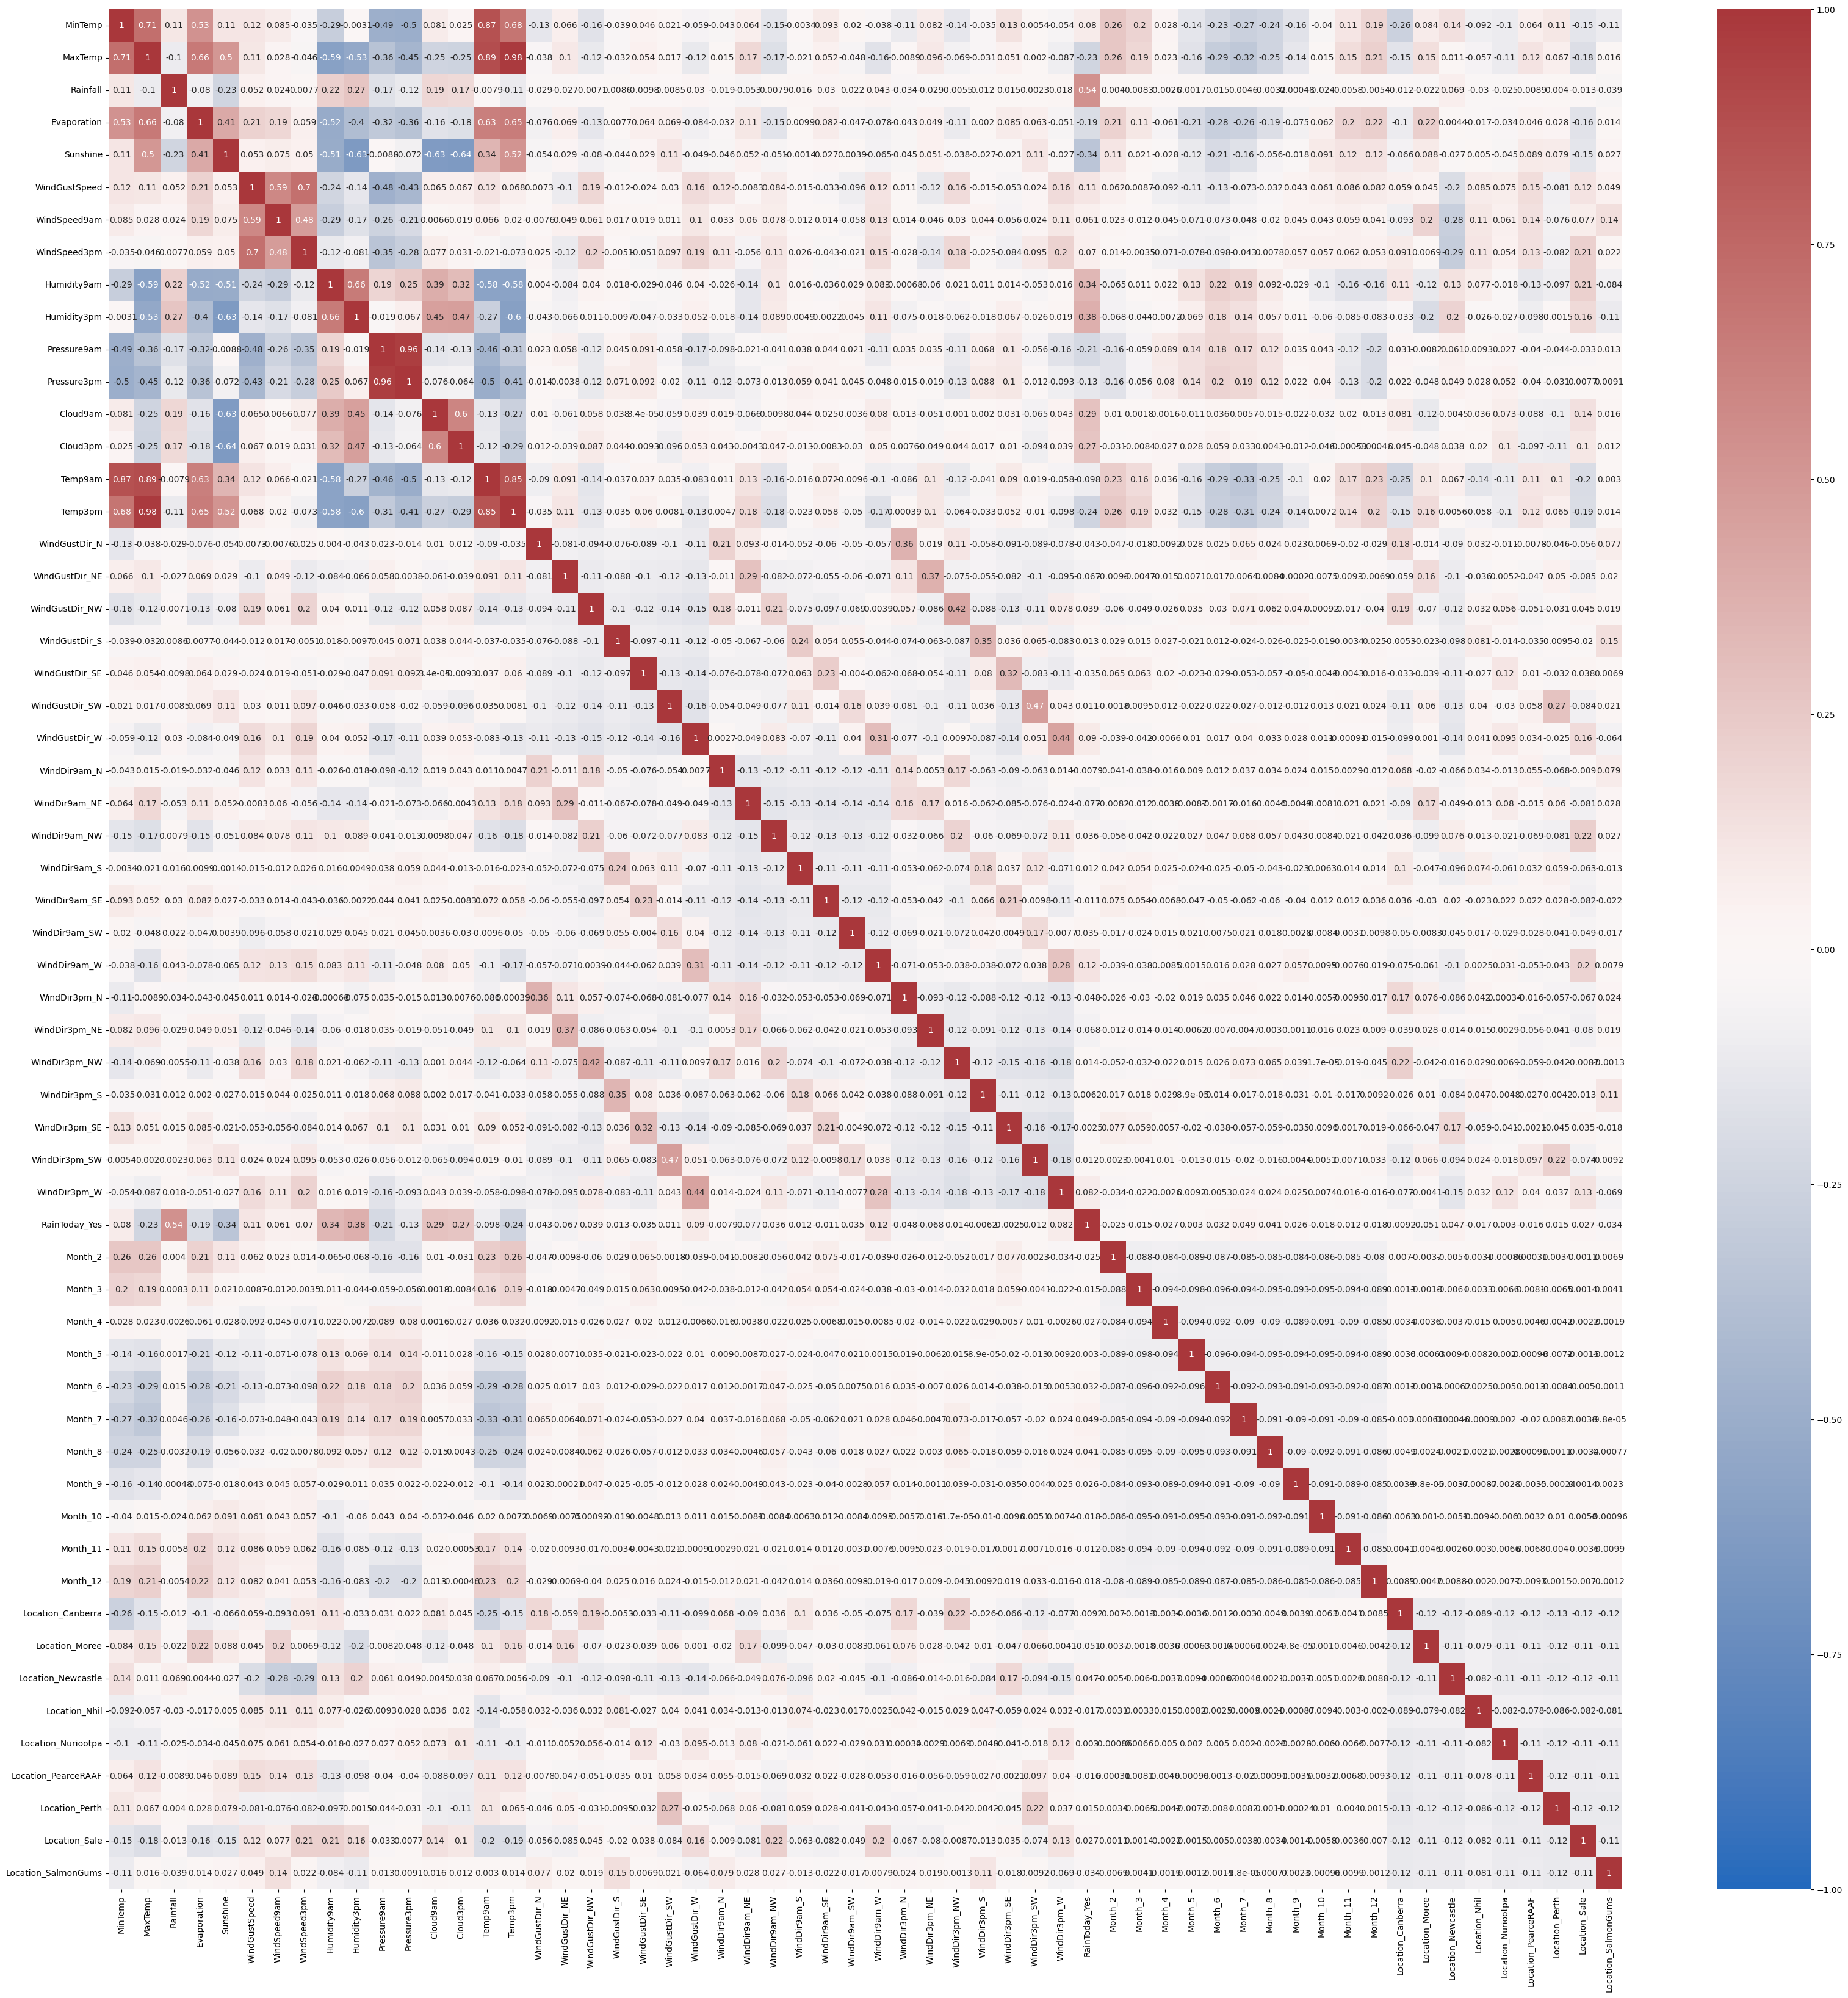

In [29]:
matriz_completa = df_train_completo.corr()

fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(matriz_completa, annot=True, vmax=1, vmin=-1, cmap='vlag')
plt.show()

vizualisacion / scatter de todo / matriz (heatmap) 

esta balanceado el dataset!? (si hay la misma cantidad de dias lluvioso de que no (NO!))